In [1]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [2]:
# import needed packages
from acs_area_statistics import acs_regional_stats, get_regions

regions = get_regions(["ncra_regions", "australia"])

In [3]:
import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob

In [4]:
# mask
# this shows fractional mask
mask_ncra = xr.open_dataset("/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i/mask-3D-frac-approx_ncra-regions.nc")['mask']
mask_aust = xr.open_dataset("/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i/mask-3D-frac-approx_australia.nc")['mask']

mask = xr.concat([mask_ncra, mask_aust], dim="region")
mask = mask.assign_coords({"region":np.arange(0,len(mask["region"]))})


In [5]:
var="TXx"

gwl_list =[]

gwls=["GWL12", "GWL15", "GWL20", "GWL30"]
for gwl in gwls:

    filelist = glob(f"/g/data/ia39/ncra/heat/data/{var}/bias-corrected/individual_models/GWL-average/{var}_AGCD-05i_*{gwl}*.nc")
    
    ds_gwl = xr.open_mfdataset(filelist, 
                               preprocess= lambda ds:ds.expand_dims({"gwl":[f"{gwl}"]}),
                               use_cftime=True,
                               combine="nested",
                               concat_dim="model",
                               combine_attrs= "drop_conflicts").load()
    gwl_list.append(ds_gwl)

ds = xr.merge(gwl_list)

# calculate the region average
dims = ("lat", "lon",)
how = ["mean",]
outfile="out.csv"

da_summary = acs_regional_stats(ds=ds, var=var, mask = mask, dims=dims, how = how, outfile=outfile)
da_summary

#find the min, mdeian and max of ensemble members
ds_min_max = xr.merge([da_summary.min(dim=["model"]).rename({f"{var}_mean":"min"}),
                        da_summary.median(dim=["model"]).rename({f"{var}_mean":"median"}),
                        da_summary.max(dim=["model"]).rename({f"{var}_mean":"max"}),])


# save to csv per region
for i, abbrev in enumerate(mask.abbrevs.values):
    df = ds_min_max.sel(region=i).to_dataframe()[["abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"{var}_{abbrev}_gwl-average.csv")

Text(0.5, 1.0, 'TXx')

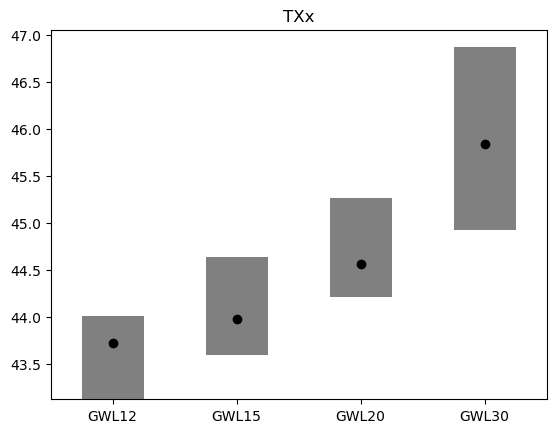

In [6]:
# make a plot from the csv

df = pd.read_csv(f"{var}_{abbrev}_gwl-average.csv", index_col="gwl")

gwls = ["GWL12", "GWL15", "GWL20", "GWL30"]
for i, gwl in enumerate(gwls):

    ens_min, ens_median, ens_max = df.loc[[gwl]][["min", "median", "max"]].values[0]
    plt.bar(x=i+1, height=ens_max - ens_min, width=0.5, bottom =  ens_min, color="grey", label=gwl)
    plt.scatter(x=i+1, y=ens_median, c="k")


plt.xlim(0.5, len(gwls)+0.5 )
plt.xticks(np.arange(1,len(gwls)+1), labels=gwls)
plt.title(var)

In [7]:
# anomalies
var="TXx"

gwl_list =[]

gwls=["GWL15", "GWL20", "GWL30"]
for gwl in gwls:

    filelist = glob(f"/g/data/ia39/ncra/heat/data/{var}/bias-corrected/individual_models/GWL-change/{var}_AGCD-05i_*{gwl}*.nc")
    
    ds_gwl = xr.open_mfdataset(filelist, 
                               preprocess= lambda ds:ds.expand_dims({"gwl":[f"{gwl}"]}),
                               use_cftime=True,
                               combine="nested",
                               concat_dim="model",
                               combine_attrs= "drop_conflicts").load()
    gwl_list.append(ds_gwl)

ds = xr.merge(gwl_list,)


# calculate the region average
dims = ("lat", "lon",)
how = ["mean",]
outfile="out.csv"

da_summary = acs_regional_stats(ds=ds, var=var, mask = mask, dims=dims, how = how, outfile=outfile)
da_summary

#find the min, mdeian and max of ensemble members
ds_min_max = xr.merge([da_summary.min(dim=["model"]).rename({f"{var}_mean":"min"}),
                        da_summary.median(dim=["model"]).rename({f"{var}_mean":"median"}),
                        da_summary.max(dim=["model"]).rename({f"{var}_mean":"max"}),])

ds_min_max.to_dataframe(dim_order=["region", "gwl"])



# save to csv per region
for i, abbrev in enumerate(mask.abbrevs.values):
    df = ds_min_max.sel(region=i).to_dataframe()[["abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"{var}_{abbrev}_gwl-change.csv")


Text(0.5, 1.0, 'TXx_AUS_gwl-change')

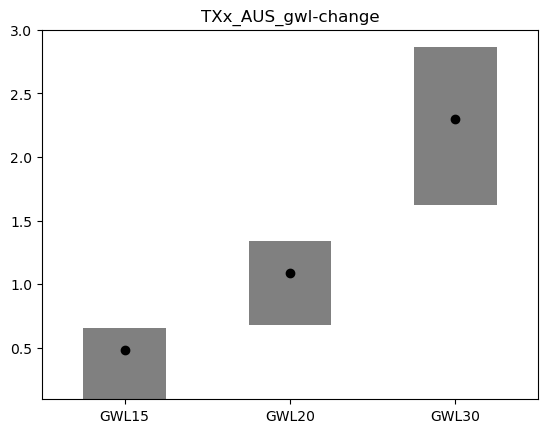

In [8]:
# make a plot from the csv

df = pd.read_csv(f"{var}_{abbrev}_gwl-change.csv", index_col="gwl")

gwls = ["GWL15", "GWL20", "GWL30"]
for i, gwl in enumerate(gwls):

    ens_min, ens_median, ens_max = df.loc[[gwl]][["min", "median", "max"]].values[0]
    plt.bar(x=i+1, height=ens_max - ens_min, width=0.5, bottom =  ens_min, color="grey", label=gwl)
    plt.scatter(x=i+1, y=ens_median, c="k")


plt.xlim(0.5, len(gwls)+0.5 )
plt.xticks(np.arange(1,len(gwls)+1), labels=gwls)
plt.title(f"{var}_{abbrev}_gwl-change")